# 1. Definition
## 1.1 Project Overview
From December 2008 until December 2018, the mean property prices in all of Norway have increased by 82%. However, for the region of Oslo, the growth for the same period was 121%[[1]](https://krogsveen.no/Boligprisstatistikk/(county)/Oslo 'Krogsveen Norge'). This complication makes the purchase of property in the biggest urban center in Norway a process having an inherent financial risk.

The purpose of this project is to provide a comprehensive view of the property market of Oslo and Akershuhs. Such analysis would inform a prudent purchase of real estate by the user in the above-mentioned areas. The main goals of investigation for the analysis are to:
* Estimate a reasonable price per square meter in various parts of Oslo and Akershus
* Understand the factors that have the highest influence on the price per square meter
* Detect areas with overvalued and undervalued real estate prices
* Find and recommend properties suitable for purchase based on the findings from this analysis

The datasets used in this analysis are:
* Real estate dataset
* Post codes dataset
* Google places dataset
* Dataset by the National Health Institute referred to also as FHI

## 1.2 Problem Statement
We need to identify patterns and relationships between various real estate features (e.g. size, number of floors, energy characteristics) and the target (price per square meter). In addition, we need to identify potential neighborhood features to augment the real estate dataset.

## 1.3 Metrics
Since our problem requires the prediction of the target value, we will utilize the following regression metrics:
* Mean Squared Error
* Median Squared Error
* Max Error
* Explained Variance
* R2 Score

# 2. Analysis
## 2.1 Data Exploration
We will start by importing the libraries we will utilize.

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing as preprocess
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import datashader as ds
from datashader import transfer_functions as tf
import utils as u

Next, we will set up our visual style for the rest of the notebook.

In [2]:
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 40)
from IPython.display import display, HTML
%matplotlib inline
sns.set(style='dark')
plt.rcParams['figure.figsize'] = [14, 10]

We will now import the main dataset.

In [3]:
queries = u.get_queries('queries')

In [4]:
bq_client = bigquery.Client()

In [5]:
data = u.get_real_estate_data(queries, bq_client)

In [6]:
data.iloc[:, 2:].head()

,new_building,num_bedrooms,floor,primary_size,total_size,price,property_type,ownership_type,construction_year,energy_character,common_expenses,brokerage_expenses,common_wealth,common_debt,address
0,True,2.0,NaN,89.0,93.0,3211622.0,Leilighet,Eier (Selveier),2019.0,B -oransje,NaN,NaN,NaN,0.0,"Siggerudbråten, ..."
1,True,2.0,2.0,89.0,93.0,3261622.0,Leilighet,Eier (Selveier),2019.0,B -oransje,NaN,NaN,NaN,0.0,"Siggerudbråten, ..."
2,True,2.0,2.0,89.0,93.0,3308582.0,Leilighet,Eier (Selveier),2019.0,B -oransje,NaN,NaN,NaN,0.0,"Siggerudbråten, ..."
3,True,2.0,2.0,89.0,93.0,3409162.0,Leilighet,Eier (Selveier),2019.0,B -oransje,NaN,NaN,NaN,0.0,"Siggerudbråten, ..."
4,True,2.0,2.0,67.0,71.0,2908582.0,Leilighet,Eier (Selveier),2019.0,B -oransje,NaN,NaN,NaN,0.0,"Siggerudbråten, ..."


We now need to inspect the number of missing values per feature.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5291 entries, 0 to 5290
Data columns (total 17 columns):
ad_id                 5291 non-null int64
apt_id                3892 non-null object
new_building          5291 non-null bool
num_bedrooms          5109 non-null float64
floor                 4287 non-null float64
primary_size          4786 non-null float64
total_size            5067 non-null float64
price                 5088 non-null float64
property_type         5289 non-null object
ownership_type        5289 non-null object
construction_year     5281 non-null float64
energy_character      1733 non-null object
common_expenses       1004 non-null float64
brokerage_expenses    1266 non-null float64
common_wealth         697 non-null float64
common_debt           1253 non-null float64
address               5289 non-null object
dtypes: bool(1), float64(10), int64(1), object(5)
memory usage: 666.6+ KB


As we can see, there are only 2 complete fields. Since our target is defined as price per square meter, we need to limit ourselves to the cases where both the `primary_size` and the `price` of each real estate object are present.

In [8]:
data = data[(data.price.notna()) & (data.primary_size.notna())].copy()

We can now sort and plot the features by the number of `NULL` values.

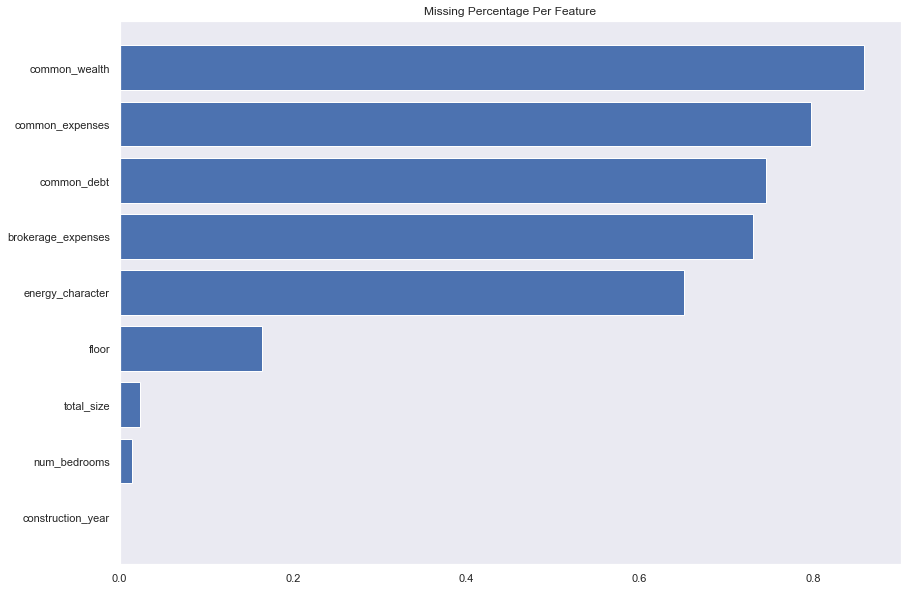

In [20]:
to_plot = data.isna().sum(axis=0).drop(['ad_id', 'apt_id']) / len(data)
to_plot = to_plot[to_plot > 0].sort_values()

top_missing_columns = list(to_plot[to_plot > 0.7].index)

plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Missing Percentage Per Feature')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

As we can see, the features with the least number of `NULL` values are: `construction_year`, `num_bedrooms`, `total_size` (expected as we filtered the missing `primary_size` values) and `address`. Conversely, the features with highes percentage of missing values are: `common_wealth`, `common_expenses`, `common_debt`, `brokerage_expenses` and `energy_character`.

It is worth mentioning that it is possible that a missing value for: `common_wealth`, `common_expenses`, `common_debt` and `brokerage_expenses` may mean that there are no such expenses / debt / eatlh (i.e. 0). We will investigate that further.

The `floor` column has about 20% (as of the time of writing of this analysis) missing values. It may be possible to infer and impute the value for this feature. Again, we will investigate that further on.

Let us now look at the distribution of `common_wealth`, `common_expenses`, `common_debt` and `brokerage_expenses`:

In [22]:
data[top_missing_columns].describe()

,brokerage_expenses,common_debt,common_expenses,common_wealth
count,1.261000e+03,1.191000e+03,951.000000,6.640000e+02
mean,1.072662e+05,7.609612e+12,3575.644585,3.001912e+04
std,1.221284e+05,1.120707e+13,1564.052117,7.985621e+04
min,0.000000e+00,0.000000e+00,83.000000,3.280000e+02
25%,1.244600e+04,7.311950e+04,2600.000000,1.128650e+04
50%,9.372200e+04,2.587890e+05,3378.000000,1.928600e+04
75%,1.549720e+05,1.800000e+13,4230.000000,3.298025e+04
max,2.001222e+06,4.095000e+13,15056.000000,1.905469e+06


As we can see, the minimum values for `brokerage_expenses` and `common_debt` are 0, which means that we cannot treat missing values as 0 too. The `common_expenses` and `common_wealth`, on the other hand have minimum values higher than 0. This means that we can investigate the latter columns further and drop the former.

One way to gain further understanding of the meaning of `NULL` values within the `common_expenses` and `common_wealth` fields is to show their aggregate values by property type. Our intuition here is that different properties are associated with different expenses and wealth.

In [23]:
data.drop(['brokerage_expenses', 'common_debt', 'energy_character'], axis=1, inplace=True)

In [26]:
pd.pivot_table(data=data, index='property_type', values=['common_expenses', 'common_wealth'], aggfunc=['min', 'median', 'max'])

min                        median                \
                  common_expenses common_wealth common_expenses common_wealth   
property_type                                                                   
Andre                       601.0           NaN           601.0           NaN   
Enebolig                     83.0       11366.0           896.5       26405.0   
Garasje/Parkering           417.0           NaN           425.0           NaN   
Leilighet                   250.0         328.0          3410.0       19436.5   
Rekkehus                    500.0        4612.0          2623.0       17970.5   
Tomannsbolig                500.0       12854.0          4051.0       33474.0   

                              max                
                  common_expenses common_wealth  
property_type                                    
Andre                       601.0           NaN  
Enebolig                   3633.0       41444.0  
Garasje/Parkering           425.0           NaN  
Leilighet                 15056.0     1905469.0  
Rekkehus                   5704.0       51930.0  
Tomannsbolig               4840.0       54094.0

Apparently, one of the maximum values is an outlier (the maximum `common_wealth` for apartments). We can display the 5 highest values and see the difference between the maximum and the second, third and fourth biggest:

In [51]:
data.common_wealth.dropna().sort_values().tail()

5273     211891.0
3599     258726.0
4970     306348.0
5156     441403.0
4826    1905469.0
Name: common_wealth, dtype: float64

In [47]:
nth_biggest = data.common_wealth.dropna().sort_values().iloc[-4]

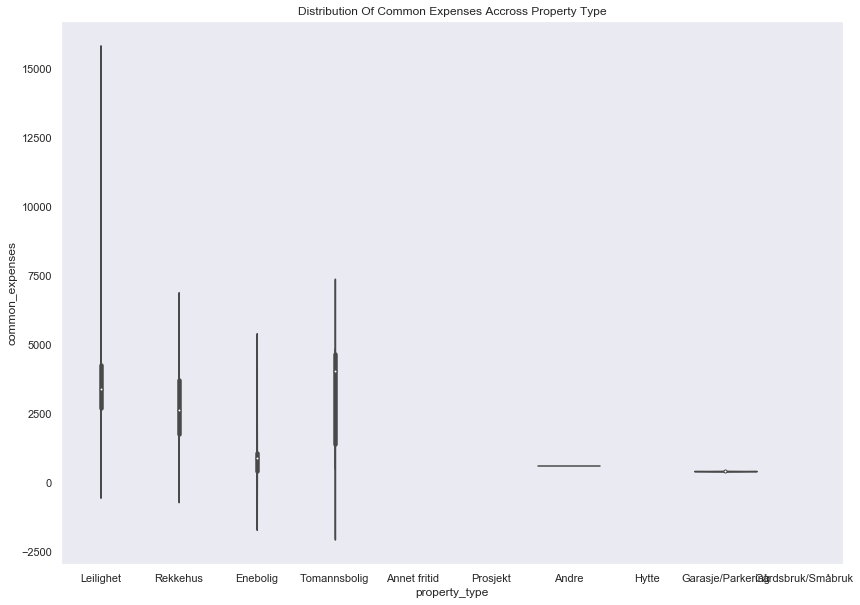

In [57]:
to_plot = data[['common_expenses', 'property_type']]
sns.violinplot(data=to_plot, x='property_type', y='common_expenses')
plt.title('Distribution Of Common Expenses Accross Property Type')
plt.show()

It seems like the common expenses vary with the type of property (considering mainly apartments, terraced houses and detached houses as other property types present a very thin selection). With a median common expenses for apartments in exccess of 3000, it seems unjustified to impute the missing values with 0. Moreover, one should expect that most real estate objects have common expenses (municipal fees, water, etc.).

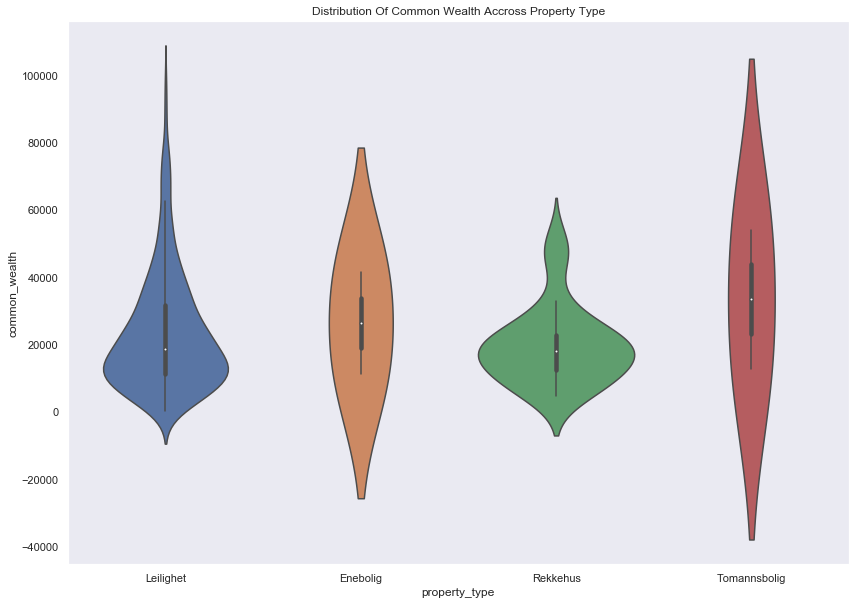

In [55]:
to_plot = data[data.common_wealth < 1e5][['common_wealth', 'property_type']]
sns.violinplot(data=to_plot, x='property_type', y='common_wealth')
plt.title('Distribution Of Common Wealth Accross Property Type')
plt.show()

We had to limit our selection to values below 100000 as a the apartment series' distribution has a very long tail. No specific pattern can be observed here. However, since `common_wealth` is not usually present for most real estate objects, we can impute it with zero values. We can then further inspect the correlation with it and the target.

In [58]:
data.drop('common_expenses', axis=1, inplace=True)

In [59]:
data['common_wealth'] = data['common_wealth'].fillna(0)

In [ ]:
data['post_code'] = data.address.apply(u.get_postcode_from_address)

In [ ]:
data['price_per_sq_m'] = data.price.div(data.primary_size).round(0)

In [ ]:
scaler = preprocess.MinMaxScaler()
data['price_per_sq_m_scaled'] = scaler.fit_transform(data['price_per_sq_m'].to_frame())

# Geographic Distribution

In [ ]:
sample_size = 1400
to_plot = data[(data.lat.notnull()) & (data.price_per_sq_m.notnull())].sample(sample_size)

m = folium.Map([59.9116, 10.7545], zoom_start=11)
#mark each station as a point
for index, row in to_plot.iterrows():
    folium.CircleMarker([row['lat'], row['lng']],
                        radius=1,
                        popup=(row['lat'], row['lng']),
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m)
#convert to (n, 2) nd-array format for heatmap
properties_array = to_plot[['lat', 'lng', 'price_per_sq_m_scaled']].values

#plot heatmap
m.add_child(plugins.HeatMap(properties_array, radius=15))
m